In [108]:
import numpy as np
%matplotlib inline
from devito import Grid, Function, TimeFunction, SparseTimeFunction, solve, Eq, Operator
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver

In [109]:
dim = 2
shape = (11, 11)
extent = (1, 1)
origin = (0, 0)
# Create a 10 x 10 grid spanning 50m x 50m
grid = Grid(shape=shape, extent=extent, origin=origin)
# Space / time order
so, to = 2, 2
# Initial velocity profile
v_initial = np.ones(shape)
# Number of boundary layers - TODO: revisit this
nbl = 0
# Instantiate model
model = Model(origin, extent, shape, so, v_initial, nbl=nbl)
# plot_velocity(model)
print(model.__dict__)

Operator `pad_vp` ran in 0.01 s


{'shape': (11, 11), 'space_order': 2, 'nbl': 0, 'origin': (0.0, 0.0), 'fs': False, 'grid': Grid[extent=(10, 10), shape=(11, 11), dimensions=(x, y)], '_physical_parameters': {'vp'}, 'damp': 1, 'vp': vp(x, y), '_dt': None, '_dt_scale': 1}


In [110]:
dt = model.critical_dt
print("dt: {:.4f}".format(dt))

dt: 0.6124


In [111]:
n_src, n_recv = 1, 5
src_coords, recv_coords = np.zeros((n_src, dim)), np.zeros((n_recv, dim))

In [112]:
src_coords[0] = [0.5, 5]

for k in range(n_recv):
    recv_coords[k] = [9.75, k * 10 / (n_recv) + 1]
print(src_coords, "\n", recv_coords)

[[0.5 5. ]] 
 [[9.75 1.  ]
 [9.75 3.  ]
 [9.75 5.  ]
 [9.75 7.  ]
 [9.75 9.  ]]


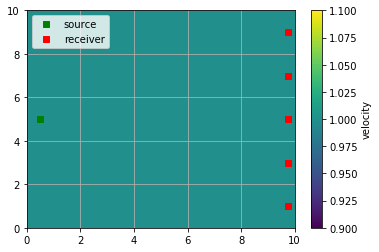

In [113]:
import matplotlib.pyplot as plt


plt.plot(src_coords[:, 0], src_coords[:, 1], 'gs', label='source')
plt.plot(recv_coords[:, 0], recv_coords[:, 1], 'rs', label='receiver')
plt.pcolor(v_initial[:-1, :-1])
plt.colorbar(label='velocity')
plt.grid()
plt.legend()

In [145]:
t0 = 0
tn = 100
time_range = TimeAxis(start=t0, stop=tn, step=dt)
f0 = 0.010
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=src_coords.shape[0], time_range=time_range)
src2 = RickerSource(name='src2', grid=model.grid, f0=f0,
                   npoint=src_coords.shape[0], time_range=time_range)

In [146]:
# src.coordinates.data[:, :] = src_coords
src2.coordinates.data[:, :] = src_coords
# rec = Receiver(name='rec', grid=model.grid, npoint=5, time_range=time_range)
rec2 = Receiver(name='rec2', grid=model.grid, npoint=5, time_range=time_range)
# rec.coordinates.data[:, :] = recv_coords
rec2.coordinates.data[:, :] = recv_coords

In [147]:
# Define our functions
# m is gonna stand for squared slowness
m = Function(name='m', grid=model.grid, space_order=so)
rho = Function(name='rho', grid=model.grid, space_order=so)
u = TimeFunction(name='u', grid=model.grid, space_order=so, time_order=to)
# Set rho's data
rho.data[:, :] = 1

u_gradient_term = (1/rho * (u.dx + u.dy))
# pde = model.m * u.dt2 - rho * (u_gradient_term.dx + u_gradient_term.dy)
# pde

In [148]:
# Instantiate the baseline PDE so that we can compare results when I set rho to be constant
baseline_pde = model.m * u.dt2 - u.laplace
baseline_pde

-Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [149]:
# stencil = Eq(u.forward, solve(pde, u.forward))
# stencil

In [150]:
baseline_stencil = Eq(u.forward, solve(baseline_pde, u.forward))
baseline_stencil

Eq(u(t + dt, x, y), dt**2*(-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)))*vp(x, y)**2)

In [151]:
# src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
# rec_term = rec.interpolate(expr=u.forward)
src2_term = src2.inject(field=u.forward, expr=src * dt**2 / model.m)
rec2_term = rec2.interpolate(expr=u.forward)

In [152]:
baseline_op = Operator(baseline_stencil + src2_term + rec2_term, subs=model.spacing_map)
# op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)

In [153]:
baseline_op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.3999999999999944e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=5.999999999999999e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=1.5000000000000004e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

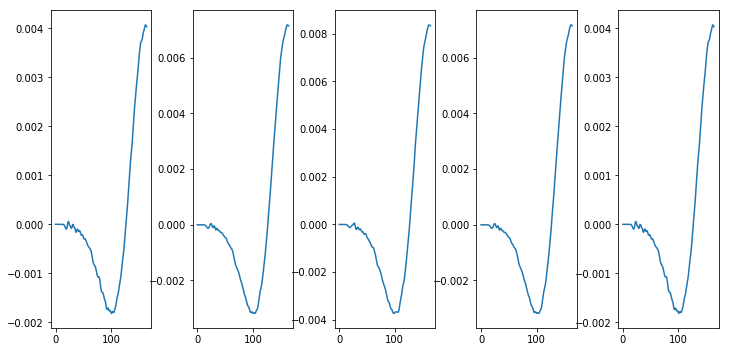

In [163]:
fig, axs = plt.subplots(1, recv_coords.shape[0], figsize=(10, 5))
fig.tight_layout()
for i, ax in enumerate(axs):
    axs[i].plot(rec2.data[:, i])